## Understanding Loop Dataset
This notebook tries provides details on the structure of the Loop dataset and makes suggestions how to process the data.

## The Loop study

**Title**: An Observational Study of Individuals with Type 1 Diabetes Using the Loop System for Automated Insulin Delivery: The Loop Observational Study (LOS)


**Description**: Passive data collection to collect data on the efficacy, safety, usability, and quality of life/ psychosocial effects of the Loop System
    
**Devices**: insulin pump and a Dexcom or Medtronic CGM

**Study Population**: People of any age with Type 1 Diabetes

### Data
The study data folder is named **Loop study public dataset 2023-01-31**

From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Tables** subfolder.

* **LOOPDeviceBasal#.txt**: #:1-3. LOOP study Basal data exported from Tidepool
* **LOOPDeviceBolus.txt**: Bolus data exported from Tidepool
* **LOOPDeviceCGM#.txt**: #;1-6. List of cgm data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Tandem pump events and the Dexcom cgm. The glossary provides information about each column. Each file contains a limited amount of columns compared to the FLAIR data. Below are **all** of the columns contained in each file

### LOOPDeviceBasal1-3
* **PtID**: Patient ID
* **DeviceDtTm**: Local device date and time; note not present in most rows because unavailable in Tidepool data source
* **UTCDtTm**: Date and time with timezone offset
* **Duration**: Actual number of milliseconds basal will be in effect
* **ExpectedDuration**: Expected number of milliseconds basal will be in effect
* **Percnt**: Percentage of suppressed basal that should be delivered
* **Rate**: Number of units per hour
* **ExtendedBolusPortion**: Flag distinguishing the immediate (Now) portion of the bolus (if any) from the extended (Later) portion [Now, Later]
* **SuprBasalType**: Suppressed basal delivery type (suppressed basal = basal event not being delivered because this one is active)
* **SuprDuration**: Suppressed duration
* **SuprRate**: Suppressed rate
* **TmZnOffset**: Timezone offset

### LOOPDeviceBolus
* **PtID**: Patient ID
* **DeviceDtTm**: Local device date and time; note not present in most rows because unavailable in Tidepool data source
* **UTCDtTm**: Device date and time (with timezone offset)
* **BolusType**: Subtype of data (ex: "Normal" and "Square" are subtypes of "Bolus" type)
* **Normal**: Number of units of normal bolus
* **ExpectedNormal**: Expected number of units of normal bolus
* **Extended**: Number of units for extended delivery
* **ExpectedExtended**: Expected number of units for extended delivery
* **Duration**: Time span over which the bolus was delivered (milliseconds for Tidepool data, minutes for Diasend data)
* **ExpectedDuration**: Expected time span over which the bolus should have been delivered (milliseconds for Tidepool data, minutes for Diasend data)
* **TmZnOffset**: Timezone offset
* **OriginName**: Data origin name
* **OriginType**: Data origin type

### LOOPDeviceCGM1-6
* **PtID**: Patient ID
* **DeviceDtTm**: Local device date and time; note not present in most rows because unavailable in Tidepool data source
* **UTCDtTm**: Device date and time (with timezone offset)
* **CGMVal**: Glucose reading from the CGM (in mmol/L from Tidepool)
* **Units**: Glucose reading units
* **DexInternalDtTm**: Dexcom Internal date and time
* **DexTrend**: Dexcom trend
* **TmZnOffset**: Timezone offset


### Notes
* There are 3 Basal files, 1 Bolus file, and 6 CGM files
* The Basal files are 2.9GB, 2.9GB, and 1.35GB in size
* The bolus file is 349 MB
* The CGM files are 2.14, 2.24, 2.3, 2.31, 2.33, and 1.53 GB
* There is exercise data contained within LOOPDeviceExercise
* There is food data within LOOPDeviceFood
* There are more patient IDs in the CGM files than in the Basal and Bolus files

### Questions
* how do we determine if the data is uploaded from Tidepool of Diasend? This effects the extended boluses

In [ ]:
import os, sys
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
from dask import dataframe as dd

%matplotlib notebook
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),'..'))
from src import cdf
from src import postprocessing

#get the file path
current_dir = os.getcwd(); 
raw_path = os.path.join(current_dir, '..', 'data', 'raw')
out_path = os.path.join(current_dir, '..', 'data', 'out')
study_name = 'Loop study public dataset 2023-01-31'
loop_path = os.path.join(raw_path, study_name)

## Inspecting CGM Data
We start by working with CGM data and understanding the datetimes. Since the data files are huge, we start with **LOOPDeviceCGM1.txt**, one of 6 CGM files, each of which are approximately 1 GB of size.

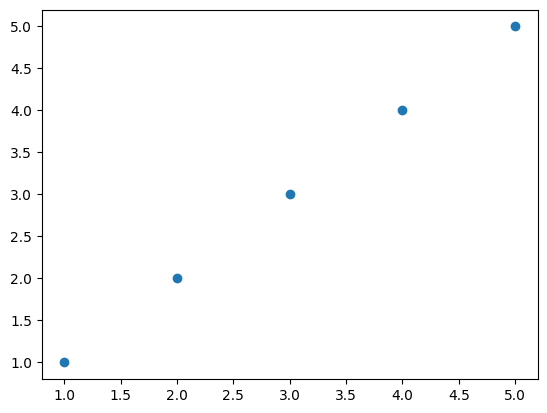

In [ ]:
import pandas as pd
from dask import dataframe as dd
from datetime import datetime, timedelta
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from src import date_helper, postprocessing, cdf

In [6]:
#define path variables
study_name = 'Loop study public dataset 2023-01-31'
raw_path = os.path.join(os.getcwd(), '..', 'data', 'raw')
out_path = os.path.join(os.getcwd(), '..', 'data', 'out')
loop_path = os.path.join(raw_path, study_name)
df_patient= pd.read_csv(os.path.join(loop_path, 'Data Tables', 'PtRoster.txt'), sep='|')

In [7]:
#inspect LOOPDeviceCGM1.txt, one of 6 CGM files.
df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',
                     usecols=['PtID', 'DeviceDtTm', 'TmZnOffset', 'UTCDtTm', 'RecordType', 'CGMVal', 'Units'])

display(df_patient.head(3))
display(df_patient.PtTimezoneOffset.value_counts())

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (before optimization)")

#optimize data by storage size
df_cgm['UTCDtTm'] = pd.to_datetime(df_cgm.UTCDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['DeviceDtTm'] = pd.to_datetime(df_cgm.DeviceDtTm, format='%Y-%m-%d %H:%M:%S')
df_cgm['TmZnOffset'] = pd.to_timedelta(df_cgm.TmZnOffset, unit='minute')

df_cgm = df_cgm.loc[df_cgm.RecordType == 'CGM'].drop(columns=['RecordType'])
df_cgm = df_cgm.drop(columns=['Units'])

memory_usage = df_cgm.memory_usage().sum() / 1024**2
print(f"Memory usage: {memory_usage:.2f} MB (after optimization)")

def count_na(series):
    return series.isna().sum()
display(df_cgm.agg(['count', count_na, 'nunique']).T)

/var/folders/m4/5d02b2xs0l52lbxzbk0t3vym0000gp/T/ipykernel_58929/1718544942.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cgm = pd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM1.txt'), sep='|',


,PtID,RecID,EnrollDt,VisitSchedStartDt,PtStatus,PtCohort,AgeAtEnrollment,LoopUseTimeAtEnroll,PtTimezoneOffset,PrefContactMethod
0,963,1,12/5/2018,12/5/2018,Completed,B,16,More than 12 months,-8.0,Email and Text
1,55,2,11/29/2018,11/29/2018,Completed,B,34,More than 12 months,-8.0,Email and Text
2,1082,3,6/5/2018,6/5/2018,Dropped,B,29,6 - 12 months,-5.0,Email and Text


PtTimezoneOffset
-5.0     380
-8.0     252
-6.0     220
-7.0      64
-9.0       1
-10.0      1
Name: count, dtype: int64

Memory usage: 1010.96 MB (before optimization)
Memory usage: 865.75 MB (after optimization)


,count,count_na,nunique
PtID,18912614,0,589
DeviceDtTm,6128194,12784420,5629581
UTCDtTm,18912614,0,14581839
CGMVal,18912614,0,315660
TmZnOffset,5917165,12995449,15


Observations:  
 - **Memory usage:** 1GB for a single CGM file is too much. The patient data is spread accross various files which requires out of memory approaches.
 - **Datetimes:** DeviceDtTm and TmznOffset are mostly NaN, as discussed with JAEB, these are the only cases where we have true (int the sense of device reported) information about local datetime and the actual time zone offset.

 Let's dive deeper into the Datetimes...

### Understanding Datetimes
Are these local times? This is what the glossary says:
 - `DeviceDtTm`: Local device date and time; note not present in most rows because unavailable in Tidepool data source
 - `UTCDtTm`: Device date and time adjusted with timezone offset
 -`DexInternalDtTm` Dexcom Internal date and time
 -`TmZnOffset`: Timezone offset

It is unclear how to obtain local times and which data to trust. 


We therefore asked JAEB the following questions.

`Time Zones`: The UTCDtTm field does not include timezone information and TmZnOffset is only available when DeviceDtTm exists, which is rare. Local time might need to be extrapolated using backward / forward filling or using PtTimezoneOffset of the patient roster, which may not be reliable over long periods. How can local times be obtained for all patients, given the limited availability of DeviceDtTm and the potential inaccuracy of PtTimezoneOffset 
> **Answer**: When we did the analysis, we used participant zip codes to estimate a local time. However, the zip code is not available in the public dataset. Instead, the variable PTTimezoneOffset in the PtRoster dataset can be applied to all UTC times to obtain a local time. During daylight savings, the offset should be reduced by 1.  This won’t be a perfect measure of the local time but should be a close approximation.

`Dexcom Times`: Are Dexcom DexInternalDtTm times in local time or UTC? 
> **Answer**: We did not use this variable because it is missing for the majority of cases.  We believe that it was only available in downloads from personal CGMs but not available in the data uploaded by Tidepool.  It may be the local time but may need to reach out to Dexcom to confirm this.


**Conclusion**: It remains unclear whether UTCDtTm is in fact in local time or utc. Therefore, the following analysis clarifies this. 

### Confirming local vs. UTC columns
Let's plot the distribution of CGM values over the course of a day using a sample of 10.000 values. 
We checked and all datetimes have a length 0f 19 characters, following this format `2018-06-06 03:52:32`

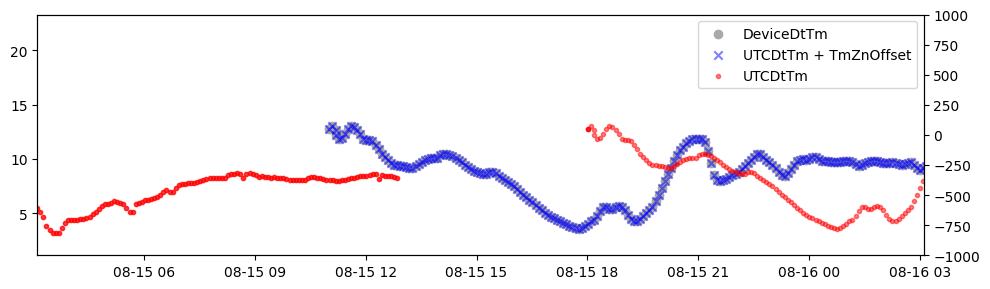

In [27]:
#ploting a single patient's CGM data
pt_grps = df_cgm.groupby('PtID', observed=False)
subframe = pt_grps.get_group(1173).copy()
subframe['AdjustedDtTm'] = subframe.UTCDtTm + pd.to_timedelta(subframe.TmZnOffset, unit='minute')

temp = subframe.dropna(subset=['DeviceDtTm']).sort_values(['DeviceDtTm'])

fig, ax = plt.subplots(figsize=(10, 3)); twinx = ax.twinx()
offset=4.5

ax.scatter(temp.DeviceDtTm, temp.CGMVal, label='DeviceDtTm', marker='o',alpha=1, color='darkgray')
ax.scatter(temp.AdjustedDtTm, temp.CGMVal, label='UTCDtTm + TmZnOffset', marker='x', alpha=0.5,color='blue')

temp = subframe.dropna(subset=['UTCDtTm']).sort_values(['UTCDtTm'])
ax.scatter(temp.UTCDtTm, temp.CGMVal, label='UTCDtTm', marker='.',alpha=0.5,color='red')
twinx.plot(temp.UTCDtTm, temp.TmZnOffset, label='TmZnOffset')

ax.set_xlim(temp.UTCDtTm.min()+timedelta(days=offset), temp.UTCDtTm.min()+timedelta(days=offset+1))
twinx.set_ylim(-1000, 1000); ax.legend(); plt.tight_layout()
plt.show()
del subframe, temp

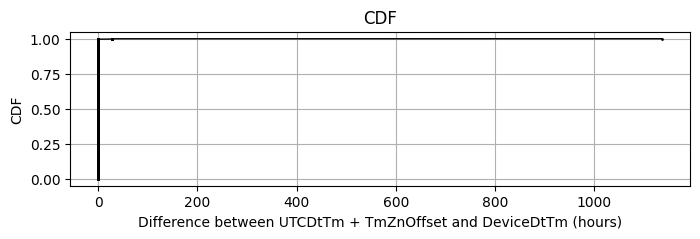

In [28]:
# plot the difference between UTCDtTm + TmZnOffset and DeviceDtTm
temp = df_cgm.sample(10000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)

temp.loc[:,'Diff'] = (temp.DeviceDtTm - (temp.UTCDtTm + pd.to_timedelta(temp.TmZnOffset, unit='minute'))).dt.total_seconds()/3600

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(temp.Diff.abs(), xlabel='Difference between UTCDtTm + TmZnOffset and DeviceDtTm (hours)', ax=ax)

We see that By adjusting UTCDtTm with the offset we obtain DeviceDtTm

```DeviceDtTm = UTCDtTm + TmZnOffset```

**Unclear: **We see some outliers from this rule. Some differences are not equal to zero. In these cases, the time shift is a fraction of hours. We don't know why that is.

This indicates that DeviceDtTm is local and UTCDtTm is in fact UTC and not time zone compensated as stated in the glossary. However, we can not rely on DeviceDtTm and TmZnOffset because it only exists for a fraction of the data. Therefore we need to rely on  UTCDtTm and convert it to local time (and we need to infer or extrapolate the TmZnOffset).

Before we do this we need to verify, once and for all if UTCDtTm column are really utc. This is because while we know the relationship, we don't know which one is which and the glossary is raising doubts. 

We do this by plotting the distributions of cgm values for both and compare. We do this using mean and std of rolling hour of day (centered). When we see clearly pronounced postprandial morning, lunch and dinner spikes, we know they are local.

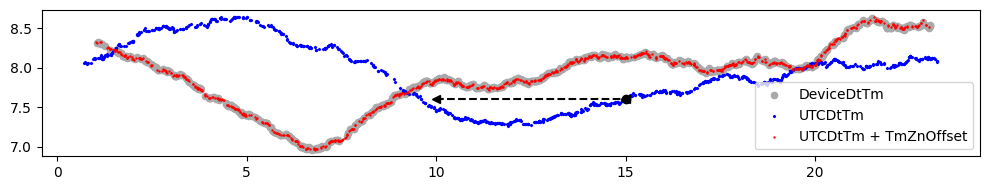

In [47]:
#plot daytime average CGM values

#reduce data to those with values in both timestamp columns
temp = df_cgm.sample(100000).dropna(subset=['UTCDtTm','DeviceDtTm','TmZnOffset'],how='any').copy()
temp['DeviceDtTm'] = pd.to_datetime(temp.DeviceDtTm)
temp['UTCDtTm'] = pd.to_datetime(temp.UTCDtTm)
temp['datetime'] = pd.to_datetime(temp.UTCDtTm) + pd.to_timedelta(temp.TmZnOffset, unit='minute')

#calculate the hour of day for each timestamp
temp['DeviceDtTm_hod'] = temp.DeviceDtTm.dt.hour+temp.DeviceDtTm.dt.minute/60+temp.DeviceDtTm.dt.second/3600
temp['UTCDtTm_hod'] = temp.UTCDtTm.dt.hour+temp.UTCDtTm.dt.minute/60+temp.UTCDtTm.dt.second/3600
temp['datetime_hod'] = temp.datetime.dt.hour+temp.datetime.dt.minute/60+temp.datetime.dt.second/3600

#calcualte centered moving average
window = 2000
ma_DeviceDtTm  = temp[['CGMVal','DeviceDtTm_hod']].sort_values('DeviceDtTm_hod').rolling(window=window, min_periods=window, on='DeviceDtTm_hod', center=True).mean().sample(1000)
ma_UTCDtTm  = temp[['CGMVal','UTCDtTm_hod']].sort_values('UTCDtTm_hod').rolling(window=window, min_periods=window, on='UTCDtTm_hod', center=True).mean().sample(1000)
ma_datetime  = temp[['CGMVal','datetime_hod']].sort_values('datetime_hod').rolling(window=window, min_periods=window, on='datetime_hod', center=True).mean().sample(1000)

#draw
plt.figure(figsize=(10,2)); 
plt.scatter(ma_DeviceDtTm.DeviceDtTm_hod, ma_DeviceDtTm.CGMVal, label='DeviceDtTm', color='darkgray', marker='o',s=20)
plt.scatter(ma_UTCDtTm.UTCDtTm_hod, ma_UTCDtTm.CGMVal, label='UTCDtTm', color='blue', marker='x',s=2)
plt.scatter(ma_datetime.datetime_hod, ma_datetime.CGMVal, label='UTCDtTm + TmZnOffset', color='red', marker='.',s=2)

plt.plot([10,15],[7.6,7.6], color='black', linestyle='--', marker='<')
plt.plot([15],[7.6], color='black', marker='o')
plt.legend(); plt.tight_layout()


From this we can clearly see 
1. DeviceDtTm and the offset compensated utc aligns with expected diurnal, postprandial patterns (pronounced peak in the morning, noon and evening). 
2. Using UTC alone (blue), the peaks are less pronounced and roughly offset by 5 hours (black arrow) (At UTC 15:00 we see the morning peak, which really is at around 10:00 (-5h). This is in line with the fact that the majority of time zone offsets is around -300 minutes (-5hours). Note that just compensating UTC by 5 hours does not give the same pronounced peaks, since there are users with other offsets, the peaks are washed out.

Note: The glossary description is misleading.
> UTCDtTm : Device date and time (with timezone offset)  

### Which Offset to use?
#### Extrapolating TmZnOffset?
Now we know that we need to use UTCDtTm and infer the patient utc offset. We check how many patients have TmZnOffset data which we could use to backward and forward fill. We do this by doing a groupby patient, agg on TmZnOffset using count>100 and a sum() on on the results divided by the group size. This gives us the fraction of patients with at least one TmZnOffset value. 

37.18% of patients have at least one timezone offset


Text(0.5, 1.0, 'Availability of timezone offsets for patients with at least one')

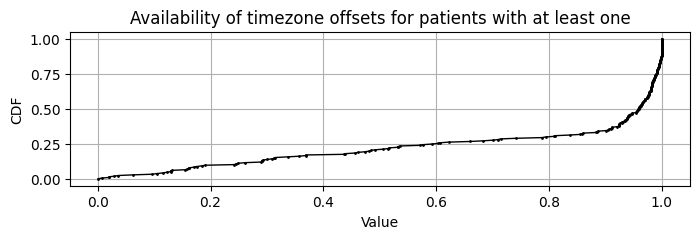

In [51]:
#check fraction of patients with at least one timezone offset
frac = (df_cgm.groupby('PtID').TmZnOffset.count()>1).sum()/df_cgm.PtID.nunique()
print(f'{frac:.2%} of patients have at least one timezone offset')

#check fraction of non NaN offsets for patients with at least one
pts_with_data = df_cgm.dropna(subset=['TmZnOffset'] ).PtID.unique()
temp = df_cgm.loc[df_cgm.PtID.isin(pts_with_data)]
temp = temp.groupby('PtID').TmZnOffset.agg(lambda x: x.notna().mean())

plt.figure(figsize=(8,2)); ax = plt.gca()
cdf.plot_cdf(temp,ax=ax)
plt.title('Availability of timezone offsets for patients with at least one')

#### Using Patient Roster UTC Offsets?
This is clearly not enough. Instead, (as JAEB mentioned) we could use the local in patient roster to do that while accounting for daylight saving time.
The Patient Roster has a column **PtTimezoneOffset** (Participant’s timezone offset) given in hours. 

We know from before that only about 1/3 of patients come with reported device timezones. For the others, we would need to use the static offset provided in the patient roster, which would give a single timezone. To understand if using this static value is acceptable, we need to understand how often the actual timezone changes. We estimate this using the device reported TmZnOffset values: 

65.3% of patients have 2 unique time zones or less


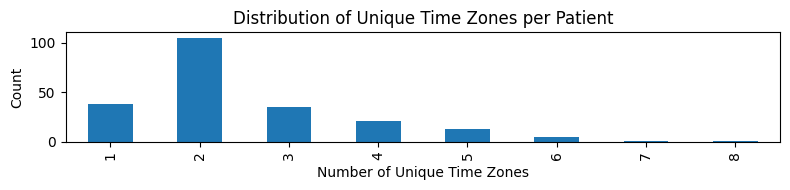

63.0% of patients have shifts of 1 hours or less


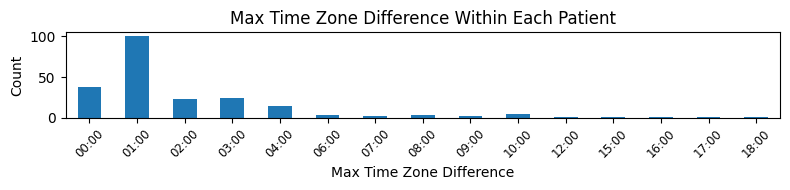

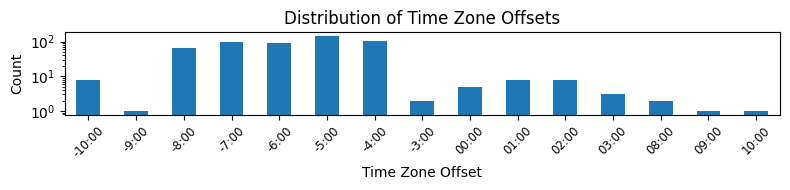

In [ ]:
def timedetla_formatter(td):
    return f"{td.seconds // 3600 + td.days * 24:02d}:{(td.seconds % 3600) // 60:02d}"

#number of time zones per patient
number_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.nunique()
number_time_zones = number_time_zones.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
number_time_zones.plot(kind='bar', ax=ax)
plt.xlabel('Number of Unique Time Zones')
plt.ylabel('Count')
plt.title('Distribution of Unique Time Zones per Patient')
plt.tight_layout(); plt.show()

print(f'{100*number_time_zones.loc[0:2].sum()/number_time_zones.sum():2.1f}% of patients have 2 unique time zones or less')


#max difference within a patient
tzdiff_within = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.agg(lambda x: x.max()-x.min())
tzdiff_within = tzdiff_within.value_counts().sort_index()

plt.figure(figsize=(8, 2)); ax=plt.gca()
tzdiff_within.plot(kind='bar', ax=ax)
tick_labels = [timedetla_formatter(x) for x in tzdiff_within.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')
plt.xlabel('Max Time Zone Difference');plt.ylabel('Count')
plt.title('Max Time Zone Difference Within Each Patient')
plt.tight_layout();plt.show()

print(f'{100*tzdiff_within[tzdiff_within.index<=timedelta(hours=1)].sum()/tzdiff_within.sum():2.1f}% of patients have shifts of 1 hours or less')


#Which time zones exist?
all_time_zones = df_cgm.dropna(subset=['TmZnOffset']).groupby('PtID', observed=False).TmZnOffset.unique().explode()
plt.figure(figsize=(8, 2)); ax=plt.gca()
all_time_zones= all_time_zones.value_counts().sort_index()
all_time_zones.plot(kind='bar', logy=True, ax=ax)
tick_labels = [timedetla_formatter(x) for x in all_time_zones.index]
ax.set_xticklabels(tick_labels, rotation=45,fontsize='small')

plt.xticks(rotation=45, fontsize='small')
plt.xlabel('Time Zone Offset'); plt.ylabel('Count'); plt.title('Distribution of Time Zone Offsets')
plt.tight_layout();plt.show()

We see that 
 - Majority of most patients experience more than 1 time zones.
 - The majority is a change of 1 hour. Likely the result of daylight saving times. 
- But, a significant fraction experiences changes of 2,3 or 4 hours or more. This is nothing, that we could account for. While we can remove patients with more frequent changes in `TmZnOffset`, almost 2/3 of the patients have no data in that column. 

However, these time zone changes are likely infrequent as most patients will travel for short periods only. 
To estimate the error, we compare the static offsets from the patient roster with the device reported offsets for those user that have it.

In [ ]:
## obtaining local times from utc and patient roster offsets
#
# joining tables
df_patient['PtTimezoneOffset'] = pd.to_timedelta(df_patient.PtTimezoneOffset, unit='hour')
df_cgm = df_cgm.join(df_patient[['PtID','PtTimezoneOffset']].set_index('PtID'), on='PtID', how='left')

# converting to localized datetime
#method 1: getting localized datetimes (much slower)
#df_cgm['datetime'] = pd.to_datetime(df_cgm.UTCDtTm, utc=True)
#df_cgm['datetime'] = df_cgm.apply(lambda x: x.datetime.tz_convert(timezone(offset=x.PtTimezoneOffset)), axis=1)

#method 2: or as naive datetime (simply adding the offset)
df_cgm['datetime']= df_cgm.UTCDtTm+ df_cgm.TmZnOffset
display(df_cgm.dropna(subset=['TmZnOffset']).sample(3))

,PtID,DeviceDtTm,UTCDtTm,CGMVal,TmZnOffset,datetime,PtTimezoneOffset
9198997,692,2018-07-07 22:19:17,2018-07-08 05:19:17,6.77191,-1 days +17:00:00,2018-07-07 22:19:17,-1 days +16:00:00
15736445,86,2018-08-25 21:04:16,2018-08-26 01:04:16,7.99308,-1 days +20:00:00,2018-08-25 21:04:16,-1 days +19:00:00
3659483,227,2018-01-15 17:50:21,2018-01-16 01:50:21,8.99221,-1 days +16:00:00,2018-01-15 17:50:21,-1 days +17:00:00


5.3% of time zone differences are >2 hours


<=0       39.958037
<=1       94.671925
<=2       96.943519
<=3       98.296482
<=4       99.120356
<=inf    100.000000
Name: Cumulative Percentage, dtype: float64

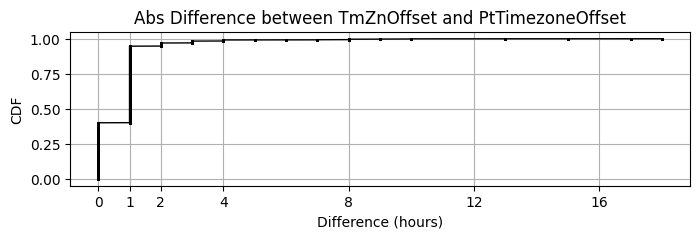

In [100]:
#plotting the difference between CGM TmZnOffset and PtTimezoneOffset
diff = df_cgm.TmZnOffset - df_cgm.PtTimezoneOffset
diff = abs(diff.dropna().dt.total_seconds()/3600)

plt.figure(figsize=(8, 2)); ax = plt.gca()
cdf.plot_cdf(diff,ax=ax); plt.xlabel('Difference (hours)');
plt.title('Abs Difference between TmZnOffset and PtTimezoneOffset');
plt.xticks([0,1,2,4,8,12,16]); #plt.tight_layout(); plt.show()

#get cumulative stats
print(f'{(diff>=2).mean():.1%} of time zone differences are >2 hours')
error_counts = diff.value_counts(bins=[-1, 0, 1, 2, 3, 4, float('inf')], sort=False)
error_percentages = (error_counts / error_counts.sum()) * 100
error_percentages.name = 'Percentage'
cumsum_report = error_percentages.cumsum()
cumsum_report.name = 'Cumulative Percentage'
cumsum_report.index = [f'<={x.right:.0f}' for x in error_counts.index]
display(cumsum_report)

**Conclusion**: When using the static patient roster utc offset, the local time error will be <2 hours for >96% of the cases.

## Managing File Sizes

Processing patient data requires us to load all files into memory at once because the patient data is spread accross all CGM files. While we could use dask and load patient data iteratively, this would create a lot of overhead. Instead, we convert the data into a paquet format, splitting it by patient id. This allows us to process patients iteratively without requiring all data to be in memory making this a more preformant option overall.

In [104]:
from dask.distributed import Client
client = Client()
loop_paquet_path = os.path.join(raw_path, 'paquet', study_name) 
re_export = False

#Convert CSVs to parquet
if re_export:
    ddf = dd.read_csv(os.path.join(loop_path, 'Data Tables', 'LOOPDeviceCGM*.txt'), sep='|', 
                    parse_dates=['UTCDtTm'], date_format='%Y-%m-%d %H:%M:%S', 
                    usecols=['PtID', 'UTCDtTm', 'RecordType', 'CGMVal'])
    ddf.to_parquet(loop_paquet_path, partition_on='PtID')

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57322 instead
  warnings.warn(


In [ ]:
# Read parquet files into dask dataframe and perform operations without executing them

#read CGM files, partitioned by PtID
ddf = dd.read_parquet(loop_paquet_path, aggregate_files='PtID')
ddf = ddf.rename(columns={'PtID': 'patient_id', 'UTCDtTm': 'UTCDtTm', 'RecordType': 'RecordType', 'CGMVal': 'cgm'})
ddf = ddf.set_index('patient_id')#,drop=False) # make sure divisions are set correctly, keep patient_id as column

#drop calibrations
ddf = ddf.loc[ddf.RecordType == 'CGM']
ddf.index = ddf.index.astype('int') #a workaround to obmit error occuring when there were no rows left
ddf = ddf.drop(columns=['RecordType'])

#convert to mg/dL
ddf['cgm'] = ddf.cgm*18.018 

#convert utc to local datetime
#TODO: When i do not rename PTID here, then result = ddf.groupby(by='patient_id').apply(postprocessing.cgm_transform); result.loc[3].compute().head(10); 
# will fail with 'KeyError: 'patient_id' this is weird because ddf.index.name still yields patient_id
patient_roster = df_patient[['PtID','PtTimezoneOffset']].rename(columns={'PtID':'patient_id'})
patient_roster = patient_roster.set_index('patient_id')
ddf = ddf.join(patient_roster, how='left')
ddf['datetime'] = ddf.UTCDtTm + dd.to_timedelta(ddf.PtTimezoneOffset, unit='hour')
ddf = ddf.drop(columns=['UTCDtTm', 'PtTimezoneOffset'])

In [175]:
patient_data = ddf.loc[3].compute()
display(patient_data.head(3))

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,cgm,datetime
3,177.023607,2018-10-15 01:23:07
3,179.023965,2018-10-15 01:18:07
3,182.025043,2018-10-15 01:13:07


### post process all CGM data using dask map_partition

In [ ]:
import time

start_time = time.time()
meta={'datetime': 'datetime64[ns]', 'cgm': 'float64'}

#Method 1: using groupby: this works but only if we previously renamed the PtID of the patient roster index to 'patient_id' before the join
result = ddf.groupby(by='patient_id').apply(postprocessing.cgm_transform, meta=meta)
display(result.loc[3].compute().head(10))
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")


start_time = time.time()
#Method 2: using map_partitions: this works but we loose the patient index, workaround:
def wrapper(df):
    assert df.index.nunique() == 1
    r= postprocessing.cgm_transform(df)
    r.assign('patient_id', df.index[0])
    
loop_cgm_transformed = ddf.map_partitions(postprocessing.cgm_transform, meta=meta)
transformed_partition = loop_cgm_transformed.get_partition(0).compute()
display(transformed_partition.head(10))
end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

#this however, does not work: after doing map_partition, using .loc[3] returns only a single row
#loop_cgm_transformed = ddf.map_partitions(postprocessing.cgm_transform, meta=meta)
#transformed_partition = loop_cgm_transformed.loc[3].compute()
#display(transformed_partition.head(10))

/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


datetime         cgm
patient_id                                  
3          0 2018-06-15 19:00:00  396.516721
           1 2018-06-15 19:05:00  394.273480
           2 2018-06-15 19:10:00  387.947360
           3 2018-06-15 19:15:00         NaN
           4 2018-06-15 19:20:00  338.812274
           5 2018-06-15 19:25:00  331.772641
           6 2018-06-15 19:30:00  325.617692
           7 2018-06-15 19:35:00         NaN
           8 2018-06-15 19:40:00  345.612267
           9 2018-06-15 19:45:00  351.902351

Execution time: 2.190506935119629 seconds


/Users/jan/.pyenv/versions/3.9.6/envs/nudgebg/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 12.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,datetime,cgm
0,2018-06-15 19:00:00,396.516721
1,2018-06-15 19:05:00,394.273480
2,2018-06-15 19:10:00,387.947360
3,2018-06-15 19:15:00,NaN
4,2018-06-15 19:20:00,338.812274
5,2018-06-15 19:25:00,331.772641
6,2018-06-15 19:30:00,325.617692
7,2018-06-15 19:35:00,NaN
8,2018-06-15 19:40:00,345.612267
9,2018-06-15 19:45:00,351.902351


Execution time: 2.196460008621216 seconds


In [ ]:
# export as CSV and parquet
loop_parquet_out_path = os.path.join(out_path, 'parquet', study_name)
loop_cgm_transformed.to_parquet(os.path.join(loop_parquet_out_path, 'cgm_transformed'))
loop_cgm_transformed.to_csv(os.path.join(loop_parquet_out_path, 'cgm_transformed.csv'));

## Test Class

In [ ]:
import os, sys
sys.path.append(os.path.join(os.getcwd(),'..'))
from src import cdf
from studies import loop
from studies.studydataset import StudyDataset
from dask.distributed import Client
#client = Client()
import importlib
importlib.reload(loop)

#get the file path
study: StudyDataset = loop.Loop(study_path=os.path.join(os.getcwd(), '..', 'data', 'raw', 'Loop study public dataset 2023-01-31'))
r = study.extract_cgm_history()
memory_size = r.memory_usage().sum() / 1024**2
print(f"Memory size of r: {memory_size:.2f} MB");


[00:01:27] Converting CGM files to parquet...
[00:01:27] Parquet file already exists. Using existing data at /Users/jan/git/nudgebg/egvinsulin/notebooks/../data/raw/Loop study public dataset 2023-01-31/../../temp/loop_cgm.parquet
[00:01:27] Extracting CGM history...
[00:01:29] PtID column data type: category
[00:01:29] Converting Dask DataFrame to pandas DataFrame
[00:02:54] compute() took: 84.93964910507202 seconds
